In this notebook we will take the mushroom images we explored in the previous notebook and try to categorize them properly. 

In [1]:
# First we'll load some relevant libraries

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import seaborn as sns
import time
%matplotlib inline
plt.style.use('seaborn-whitegrid')

os.getcwd()

'/notebooks'

In [2]:
print(os.listdir("../storage/Mushrooms"))

['Hygrocybe', 'Boletus', 'Cortinarius', '.ipynb_checkpoints', 'Russula', 'Suillus', 'Entoloma', 'Amanita']


In [3]:
%reload_ext autoreload
%autoreload 2

This notebook originates from a Tensorflow notebook on Paperspace Gradient. We'll load the relevant libraries for the model, including ResNet50, a Residual Network model commonly used in computer vision tasks where transfer learning can help improve both the speed and accuracy of a model. 

In [4]:
import tensorflow as tf
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

ResNet50 comes preloaded with different weights, depending on what it was previously trained on. Here we'll use the "imagenet" weights to preload our model. Note the extremely deep nature of this learning network. 

In [5]:
# Load ResNet50 model:
resnet_model = ResNet50(weights="imagenet")
resnet_model.summary()

W1223 21:58:05.358144 139735872776000 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [6]:
#Based on trial and error, we arrive at 300x300 and a good image size to resize each image to. 

img_rows=300
img_cols=300

In [7]:
# We'll use these libraries to Imgae processing.

from PIL import Image
import glob

In [8]:
cats = os.listdir("../storage/Mushrooms")

In [9]:
cats

['Hygrocybe',
 'Boletus',
 'Cortinarius',
 '.ipynb_checkpoints',
 'Russula',
 'Suillus',
 'Entoloma',
 'Amanita']

In [10]:
del cats[3]

The list "cats" represents the seven mushroom we will classify here. Each mushroom is a subfolder of images from that specific genus. 

In [11]:
cats

['Hygrocybe',
 'Boletus',
 'Cortinarius',
 'Russula',
 'Suillus',
 'Entoloma',
 'Amanita']

In [12]:
# We'll create another list, this tracks the number of useable files in each subfolder for later use when we label the images.

lengths = []

for k in np.arange(len(cats)):
    bad = 0
    filelist = os.listdir("../storage/Mushrooms/"+cats[k])
    for x in filelist:
        if x[-1] != 'g':   #When a non-jpeg file is found, the counter called "bad" increments.
            bad = bad + 1
    lengths.append(len(filelist)-bad)

In [13]:
# Here's an example of a file list that contains an item that's not a jpg image.
# (If you scroll down you'll see an ipynb file. )

os.listdir("../storage/Mushrooms/"+cats[6])

['446_NSCwevmikZY.jpg',
 '161_n8NbNSHDNfw.jpg',
 '057_kcgTzjdCH98.jpg',
 '061_7NVKydh43k4.jpg',
 '157_9lP2v8GCyOo.jpg',
 '472_vxTtgNhg7lc.jpg',
 '748_iWLxylB00lM.jpg',
 '749_Kwa9kDjoczs.jpg',
 '360_93di97sjY40.jpg',
 '519_B6JXPwmtHAc.jpg',
 '581_MFN1aDZ95Hs.jpg',
 '105_xRDlUeVh5-c.jpg',
 '350_NTLs0NL3l08.jpg',
 '782_fqegXGS2jxM.jpg',
 '303_db7f-9_bQu0.jpg',
 '451_V0quFnk9NFA.jpg',
 '011_DoZoYI2vj20.jpg',
 '103_PteuQn34t3Q.jpg',
 '392_dnsTD3pYLG0.jpg',
 '131_dvJEzL2mKmA.jpg',
 '447_YuqrlLRUFco.jpg',
 '480_808xmF4b26Y.jpg',
 '508_DMB-oiAz_yg.jpg',
 '584_fegtvHpgi44.jpg',
 '074_8NADYXweiPY.jpg',
 '619_4lsqCR9RAj4.jpg',
 '212_FiQaXKH5K-Y.jpg',
 '208_EvpNOUGmeVI.jpg',
 '759_6SqS62h11EE.jpg',
 '089_gVYja0jrLJQ.jpg',
 '745_-WeedYJs__8.jpg',
 '097_SpgTx-oyDS8.jpg',
 '150_vJrbkDOJ-OE.jpg',
 '236_ijeoCeaNF_o.jpg',
 '378_Vp82kVzJkSM.jpg',
 '021_2-PKYWYCnqU.jpg',
 '331_za5pbjsDXLU.jpg',
 '681_kHekfyrqLHs.jpg',
 '365_rZaaSTiJwf4.jpg',
 '121_0mE3kiyOk4k.jpg',
 '520_7tXL64TQTpg.jpg',
 '400_yn4KopLU0P

In [14]:
lengths

[277, 304, 305, 310, 299, 276, 275]

In [15]:
#from scipy import misc

## Processing the images into an array ##

The most barebones way of reading the images into the model is as an array. Here, "train_data" will be the array that we will pull training, validation and testing sets from.  

While we're creating this list, we'll also do some data augmentation; specifically, for each image we'll make copy images that are flipped and rotated. This will help, to some extent anyway, with overfitting. 

In [16]:
train_data = []


for k in np.arange(len(cats)):

    for filename in glob.glob('../storage/Mushrooms/'+ cats[k] +'/*.jpg'): #assuming jpg
        im=Image.open(filename)

        im1 = im.resize((img_rows,img_cols))  # Use the image size we declared above
        im2 = im1.transpose(Image.FLIP_LEFT_RIGHT) # Create a image copy that's flipped
        #im3 = im1.transpose(Image.ROTATE_45)  # Create an image copy that's rotated. 
#        im3 = im1.rotate(15)
        im1 = np.asarray( im1, dtype="int32" )
        train_data.append(im1)
        im2 = np.asarray(im2, dtype = 'int32')
        train_data.append(im2)
#        im3 = np.asarray(im3, dtype = 'int32')
#        train_data.append(im3)


In [17]:
train_data = np.asarray(train_data)

In [18]:
# Here we'll use the lengths list we created earlier to generate our label set.
# We multiply each item in the list by three since we made two copies in train_data above. 
# We shoudl end up with the same number of rows as in train_data. 

#train_labels = np.concatenate((np.zeros((lengths[0]*3,), dtype=int),np.ones((lengths[1]*3,), dtype=int), np.repeat(2,lengths[2]*3),np.repeat(3,lengths[3]*3),np.repeat(4,lengths[4]*3), np.repeat(5,lengths[5]*3),np.repeat(6,lengths[6]*3)),axis=0)
train_labels = np.concatenate((np.zeros((lengths[0]*2,), dtype=int),np.ones((lengths[1]*2,), dtype=int), np.repeat(2,lengths[2]*2),np.repeat(3,lengths[3]*2),np.repeat(4,lengths[4]*2), np.repeat(5,lengths[5]*2),np.repeat(6,lengths[6]*2)),axis=0)

print(train_labels, train_labels.shape)

[0 0 0 ... 6 6 6] (4092,)


## Randomizing the images ##  
None of the mushroom folders are random selections of images; Similar-looking mushroom images are sort of grouped together, in fact. To deal with this, we'll use train-test-split techniques to randomize what goes into the various datasets. 

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# We will hold out 10% of the full data array for testing at the end. 

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size = 0.1, random_state=20)

In [21]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3682, 300, 300, 3) (410, 300, 300, 3) (3682,) (410,)


In [22]:
# Last step to prep the datasets is to one-hot encode the categories (0 through 6) into seven different columns.


train_labels = tf.keras.utils.to_categorical(y_train)
test_labels = tf.keras.utils.to_categorical(y_test)

In [23]:
print(X_train.shape, train_labels.shape)

(3682, 300, 300, 3) (3682, 7)


## Model Creation & Comparison ##
### First Model: Dummy #  


Our first model will be of the simplest kind: A random assignment of each mushroom to one of the seven mushroom categories. For this kind of regression, we would expect to be correct about 1/n of the time, n being the number of categories:

In [24]:
from sklearn.dummy import DummyClassifier

In [25]:
# Dummy model based on stratificaation:

dummy = DummyClassifier(strategy='stratified', random_state=13)

dummy.fit(X_train, y_train)

dummy.score(X_test, y_test)

0.13902439024390245

Indeed, the accuracy scored on the test set is less than 17%.  

### Second Model: Convolutional Neural Network #   

Here we will build a "somewhat deep" neural network to see the improvement possible without too much computational expense. 

In [26]:
categories = len(cats)

model = Sequential()
model.add(Conv2D(5, kernel_size=(3,3), activation='relu',input_shape=(img_rows, img_cols,3)))
model.add(MaxPool2D(2))
#model.add(Dropout(0.25))
model.add(Conv2D(15, kernel_size=(3,3), activation='relu'))
#model.add(Conv2D(15, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(15, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(2))
model.add(Flatten())
#model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.35))
model.add(Dense(categories, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 5)       140       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 5)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 15)      690       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 15)        2040      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 15)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18375)             0

In [27]:
#  The model is compiled with categorical crossentropy and accuracy as the guiding metric. 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Introduce callbacks to be exercised during training:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_acc', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1,
                              mode='max', cooldown=2, patience=2, min_lr=0)

In [29]:
# Train new model:
history = model.fit(X_train, train_labels, validation_split=0.2, epochs=50, callbacks=[reduce_lr, early_stop])

Train on 2945 samples, validate on 737 samples
Epoch 1/50
2945/2945 [==============================] - 9s 3ms/sample - loss: 32.2051 - acc: 0.1657 - val_loss: 1.9350 - val_acc: 0.1927
Epoch 2/50
2945/2945 [==============================] - 7s 2ms/sample - loss: 1.7106 - acc: 0.3138 - val_loss: 1.9824 - val_acc: 0.2225
Epoch 3/50
2945/2945 [==============================] - 7s 2ms/sample - loss: 1.2134 - acc: 0.5497 - val_loss: 2.2982 - val_acc: 0.2252
Epoch 4/50
2945/2945 [==============================] - 7s 2ms/sample - loss: 0.7771 - acc: 0.7216 - val_loss: 2.4009 - val_acc: 0.2307
Epoch 5/50
2945/2945 [==============================] - 7s 2ms/sample - loss: 0.5121 - acc: 0.8275 - val_loss: 2.9606 - val_acc: 0.2497
Epoch 6/50
2945/2945 [==============================] - 7s 3ms/sample - loss: 0.3620 - acc: 0.8876 - val_loss: 3.1629 - val_acc: 0.2782
Epoch 7/50
2945/2945 [==============================] - 7s 2ms/sample - loss: 0.3064 - acc: 0.9097 - val_loss: 3.1785 - val_acc: 0.2578


In [30]:
loss, accuracy = model.evaluate(X_test, test_labels, verbose=2)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

410/410 - 1s - loss: 3.2921 - acc: 0.2439
Model performance on test images:
Accuracy = 0.24390244483947754
Loss = 3.2920670974545363


While the CNN model did outperform random chance, the results were not by a whole lot. Interestingly, this kind of network seems to perform very admirably when presented with just two categories to identify (e.g., a dataset consisting of Boletus and Russula mushrooms only), with accuracy exceeding 70%. But when presented with seven classes of mushrooms, it appears there is too much nuance for this network to pick up. 

### Third Model: ResNet50 #  


In [31]:
categories = len(cats)

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

model.add(ResNet50(include_top = False, pooling = 'max', weights = 'imagenet'))

model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(categories, activation = 'softmax'))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                

In [32]:
# Through more trial and error it was found that redusing learning rate helped overall test set accuracy.
# Here we will set the lr to 1E-7:

tf.keras.optimizers.Adam(learning_rate=0.00000001)

In [33]:
#  The model is compiled with categorical crossentropy and accuracy as the guiding metric. 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

EarlyStopping and lr reduction on plateau are two useful techniques to dealing with models that tend to plateau. If the model flattens out too much, it will quit before it reaches the full number of iterations, or epochs. 

In [34]:
# Introduce callbacks to be exercised during training:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_acc', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1,
                              mode='max', cooldown=2, patience=2, min_lr=0)

## Modeling and Performance ##  

With the model set up above, we'll run for 50 epochs, peeling off 20% of the training set as a validation set to see how we're doing along the way.

In [35]:
# Train new model:
history = model.fit(X_train, train_labels, validation_split=0.2, epochs=50, callbacks=[reduce_lr, early_stop])

Train on 2945 samples, validate on 737 samples
Epoch 1/50
2945/2945 [==============================] - 51s 17ms/sample - loss: 0.7822 - acc: 0.7304 - val_loss: 0.6494 - val_acc: 0.7897
Epoch 2/50
2945/2945 [==============================] - 45s 15ms/sample - loss: 0.1461 - acc: 0.9671 - val_loss: 0.5368 - val_acc: 0.8046
Epoch 3/50
2945/2945 [==============================] - 45s 15ms/sample - loss: 0.0645 - acc: 0.9891 - val_loss: 0.4453 - val_acc: 0.8372
Epoch 4/50
2945/2945 [==============================] - 45s 15ms/sample - loss: 0.0405 - acc: 0.9935 - val_loss: 0.4266 - val_acc: 0.8467
Epoch 5/50
2945/2945 [==============================] - 45s 15ms/sample - loss: 0.0324 - acc: 0.9935 - val_loss: 0.4418 - val_acc: 0.8372
Epoch 6/50
2945/2945 [==============================] - 46s 16ms/sample - loss: 0.0345 - acc: 0.9919 - val_loss: 0.5863 - val_acc: 0.8046
Epoch 7/50
2945/2945 [==============================] - 45s 15ms/sample - loss: 0.0221 - acc: 0.9963 - val_loss: 0.4790 - val

In [36]:
# Loss during training:
history_frame = pd.DataFrame(history.history)

Text(0.5, 0, 'Epochs')

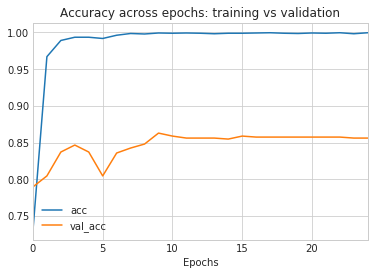

In [37]:
history_frame.loc[:,['acc','val_acc']].plot()
plt.title('Accuracy across epochs: training vs validation')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

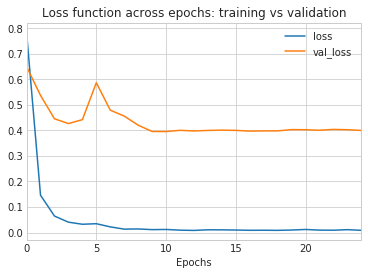

In [38]:
history_frame.loc[:,['loss','val_loss']].plot()
plt.title('Loss function across epochs: training vs validation')
plt.xlabel('Epochs')

In [39]:
loss, accuracy = model.evaluate(X_test, test_labels, verbose=2)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

410/410 - 6s - loss: 0.3754 - acc: 0.8780
Model performance on test images:
Accuracy = 0.8780487775802612
Loss = 0.37541265342293717


## Results ##  

So, the model managed to achieve nearly 88% accuracy on the unseen, randomized test set. This definitely puts this model out of my league - there's no way I could get even close to that accuracy on the test set. For example, in my preliminary look at ten of the test set images, I managed to correctly guess just THREE of them. That's 30%. 

In [40]:
from sklearn.metrics import confusion_matrix

In [41]:
y_pred = model.predict_classes(X_test)

In [42]:
df = pd.DataFrame(confusion_matrix(y_test, y_pred))

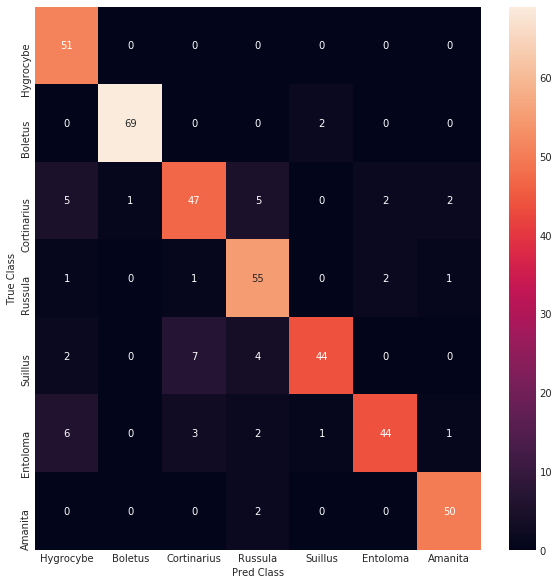

In [43]:


plt.figure(figsize=[10,10])
ax = sns.heatmap(df, annot=True, fmt='d',xticklabels=cats, yticklabels=cats)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
#sns.heatmap(df, annot=True)
plt.ylabel('True Class'), plt.xlabel('Pred Class')
plt.show()

Here we will introduce a function that will take the dataframe from the confusion matrix and extract the standard classification metrics. First we will calculate for each mushroom genus the True Positives, False Positives, True Negatives and False Negatives, and from these values obtain for each genus the:  

Accuracy (whether or not a specific image is that particular genus or not),  

Precision (how many of the correctly predicted cases actually turned out to be positive),  

Recall (how many of the actual positive cases we were able to predict correctly), and 

F1-score (a combined Precision and Recall score).

In [69]:
def scores(df, cats):
    conf = {}
    total = df.sum().sum()
    
    for i in np.arange(len(cats)):
        tp = df.loc[i][i]
        fn = df.loc[i].sum() - tp
        fp = df[i].sum() - tp
        tn = total - tp - fn - fp
        acc = (tp + tn) / total     # Accuracy
        Prec = tp / (tp + fp)       # Precision
        Rec = tp / (tp + fn)        # Recall
        f1 = 2 / (1/Prec + 1/Rec)   # F1-score
        conf[cats[i]] = [tp, fp, tn, fn, acc, Prec, Rec, f1]
    
    conf = pd.DataFrame(conf).T
    conf.columns = ['TP', 'FP', 'TN', 'FN', 'Accuracy', 'Precision', 'Recall', 'F1-score']
    
    return conf
    

In [70]:
conf = scores(df, cats)
conf

,TP,FP,TN,FN,Accuracy,Precision,Recall,F1-score
Hygrocybe,51.0,14.0,345.0,0.0,0.965854,0.784615,1.000000,0.879310
Boletus,69.0,1.0,338.0,2.0,0.992683,0.985714,0.971831,0.978723
Cortinarius,47.0,11.0,337.0,15.0,0.936585,0.810345,0.758065,0.783333
Russula,55.0,13.0,337.0,5.0,0.956098,0.808824,0.916667,0.859375
Suillus,44.0,3.0,350.0,13.0,0.960976,0.936170,0.771930,0.846154
Entoloma,44.0,4.0,349.0,13.0,0.958537,0.916667,0.771930,0.838095
Amanita,50.0,4.0,354.0,2.0,0.985366,0.925926,0.961538,0.943396


## Exploring improperly categorized images ##  

What do some of the incorrectly categorized images look like? 

In [44]:
incorrects = np.nonzero(model.predict_classes(X_test).reshape((-1,)) != y_test)

(-0.5, 299.5, 299.5, -0.5)

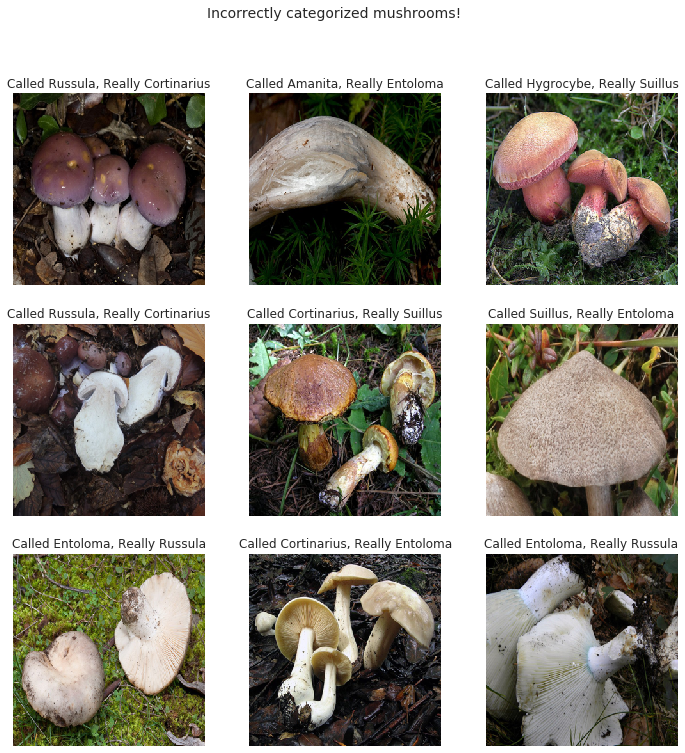

In [45]:
f, axarr = plt.subplots(3,3, figsize = (12, 12))
f.suptitle("Incorrectly categorized mushrooms!", fontsize=14)
axarr[0,0].imshow(X_test[incorrects[0][0]])
string = 'Called ' + cats[y_pred[incorrects[0][0]]]+ ", Really "+ cats[y_test[incorrects[0][0]]]
axarr[0,0].set_title(string)
axarr[0,0].axis('off')
axarr[0,1].imshow(X_test[incorrects[0][1]])
string = 'Called ' + cats[y_pred[incorrects[0][1]]]+ ", Really "+ cats[y_test[incorrects[0][1]]]
axarr[0,1].set_title(string)
axarr[0,1].axis('off')
axarr[0,2].imshow(X_test[incorrects[0][2]])
string = 'Called ' + cats[y_pred[incorrects[0][2]]]+ ", Really "+ cats[y_test[incorrects[0][2]]]
axarr[0,2].set_title(string)
axarr[0,2].axis('off')
axarr[1,0].imshow(X_test[incorrects[0][3]])
string = 'Called ' + cats[y_pred[incorrects[0][3]]]+ ", Really "+ cats[y_test[incorrects[0][3]]]
axarr[1,0].set_title(string)
axarr[1,0].axis('off')
axarr[1,1].imshow(X_test[incorrects[0][4]])
string = 'Called ' + cats[y_pred[incorrects[0][4]]]+ ", Really "+ cats[y_test[incorrects[0][4]]]
axarr[1,1].set_title(string)
axarr[1,1].axis('off')
axarr[1,2].imshow(X_test[incorrects[0][5]])
string = 'Called ' + cats[y_pred[incorrects[0][5]]]+ ", Really "+ cats[y_test[incorrects[0][5]]]
axarr[1,2].set_title(string)
axarr[1,2].axis('off')
axarr[2,0].imshow(X_test[incorrects[0][6]])
string = 'Called ' + cats[y_pred[incorrects[0][6]]]+ ", Really "+ cats[y_test[incorrects[0][6]]]
axarr[2,0].set_title(string)
axarr[2,0].axis('off')
axarr[2,1].imshow(X_test[incorrects[0][7]])
string = 'Called ' + cats[y_pred[incorrects[0][7]]]+ ", Really "+ cats[y_test[incorrects[0][7]]]
axarr[2,1].set_title(string)
axarr[2,1].axis('off')
axarr[2,2].imshow(X_test[incorrects[0][8]])
string = 'Called ' + cats[y_pred[incorrects[0][8]]]+ ", Really "+ cats[y_test[incorrects[0][8]]]
axarr[2,2].set_title(string)
axarr[2,2].axis('off')

Based on these few examples, it seems like the model is having trouble with Entoloma mushrooms. Some of these instances can perhaps be attributed to less-than-optimal image quality. However, the model does get some things wrong. For example, I think a trained human expert would have noticed the lack of gills as being a sign as being most likely either a Boletus or a Suillus. Two of the Suillus images above should perhaps have been caught.But overall, an accuracy of > 85% on this rather challenging image set is pleasing!. 